In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
import pandas as pd
import h5py
import imageio
from rich.progress import track as progress
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import scipy.ndimage
import scipy.stats
from scipy.optimize import minimize_scalar
import cv2

import sleap
sleap.versions()

2023-05-10 17:34:46.204197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/remoras/lib/python3.7/site-packages/cv2/../../lib64:
2023-05-10 17:34:46.204225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


SLEAP: 1.3.0
TensorFlow: 2.8.4
Numpy: 1.21.6
Python: 3.7.12
OS: Linux-5.4.0-139-generic-x86_64-with-debian-bookworm-sid


# Preprocessing

In [2]:
shark_slp_files = """
data/shark.video_1.slp
data/shark.video_2.slp
data/shark.video_3.slp
data/shark.video_4.slp
""".strip().split()

remora_slp_files = """
data/remora.video_1.slp
data/remora.video_2.slp
data/remora.video_3.slp
data/remora.video_4.slp
""".strip().split()


def load_tracks(slp_file):
    labels = sleap.load_file(slp_file)
    n_frames = len(labels.video)
    n_nodes = len(labels.skeleton)
    n_tracks = max(len(labels.tracks), 1)
    is_single_instance = n_tracks <= 1

    tracks = np.full((n_frames, n_tracks, n_nodes, 2), np.nan)
    for lf in labels:
        frame_ind = lf.frame_idx
        for inst in lf:
            if inst.track is None:
                if is_single_instance:
                    track_ind = 0
                else:
                    continue
            else:
                track_ind = labels.tracks.index(inst.track)

            tracks[frame_ind, track_ind] = inst.numpy()
    
    return tracks


remora_tracks = [load_tracks(p) for p in remora_slp_files]
remora_skeleton = sleap.load_file(remora_slp_files[0]).skeleton
remora_nodes = remora_skeleton.node_names
# remora_tracks[2] = remora_tracks[2][:, :5]  # crop extraneous/short tracks in video_3


shark_tracks = [load_tracks(p).squeeze() for p in shark_slp_files]
shark_skeleton = sleap.load_file(shark_slp_files[0]).skeleton
shark_nodes = shark_skeleton.node_names

print("Remora:", remora_nodes)
print("Shark:", shark_nodes)

print(f'remora tracks of shape: {[x.shape for x in remora_tracks]}')
print(f'shark tracks of shape: {[x.shape for x in shark_tracks]}')

Remora: ['head', 'f_dorsal', 'r_dorsal']
Shark: ['mouth', 'l_mouth', 'l_head', 'r_mouth', 'r_head']
remora tracks of shape: [(763, 3, 3, 2), (275, 4, 3, 2), (568, 10, 3, 2), (602, 5, 3, 2)]
shark tracks of shape: [(763, 5, 2), (275, 5, 2), (568, 5, 2), (602, 5, 2)]


In [3]:
SHARK_CENTROID_NODE = shark_nodes.index('mouth')
REMORA_CENTROID_NODE = remora_nodes.index('f_dorsal')
SHARK_CENTROID_NODE, REMORA_CENTROID_NODE

(0, 1)

In [4]:
def fill_missing(x, kind="nearest", limit_direction="both", limit_area="inside", limit=5, **kwargs):
    """Fill missing values in a timeseries.
    
    Args:
        x: Timeseries of shape (time, ...).
        kind: Type of interpolation to use. Defaults to "nearest".
    
    Returns:
        Timeseries of the same shape as the input with NaNs filled in.
    
    Notes:
        This uses pandas.DataFrame.interpolate and accepts the same kwargs.
    """
    return pd.DataFrame(x.reshape(len(x), -1)).interpolate(kind=kind, axis=0, limit_direction=limit_direction, limit_area=limit_area, limit=limit, **kwargs).to_numpy().reshape(x.shape)


def smooth_diff(node_loc, win=25, poly=3, order=0):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=order)
    
    # node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_loc_vel


def connected_components1d(x, return_limits=False):
    """Return the indices of the connected components in a 1D logical array.
    
    Args:
        x: 1d logical (boolean) array.
        return_limits: If True, return indices of the limits of each component rather
            than every index. Defaults to False.
            
    Returns:
        If return_limits is False, a list of (variable size) arrays are returned, where
        each array contains the indices of each connected component.
        
        If return_limits is True, a single array of size (n, 2) is returned where the
        columns contain the indices of the starts and ends of each component.
    """
    L, n = scipy.ndimage.label(x.squeeze())
    ccs = scipy.ndimage.find_objects(L)
    starts = [cc[0].start for cc in ccs]
    ends = [cc[0].stop for cc in ccs]
    if return_limits:
        return np.stack([starts, ends], axis=1)
    else:
        return [np.arange(i0, i1, dtype=int) for i0, i1 in zip(starts, ends)]
    
    
def lims_to_mask(lims, size=None):
    """Convert limits to a mask.
    
    Args:
        lims: Indices of limits as an array of shape (n, 2).
        size: Number of elements in the vector. If not provided, uses the largest limit.
    
    Returns:
        A logical vector of shape (size,) where elements whose indices are contained in
        the input lims are True.
    """
    if not isinstance(lims, np.ndarray):
        lims = np.array(lims)
    lims = lims.astype(int)
    if size is None:
        size = lims.max()
    mask = np.full((size,), False)
    for i0, i1 in lims:
        mask[i0:i1] = True
    return mask

def obj_fun(anchor_pose, pose):
    """Derive objective function for rotation matrix optimization.
    
    Args:
        anchor_pose: Pose we want to approximate of shape (# nodes, 2).
        pose: Pose we are trying to transform from of shape (# nodes, 2).
    
    Returns:
        A function that is the L2 distance between the two poses. 
    """
    return lambda x: np.linalg.norm(np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]]) @ pose.T - anchor_pose.T) **2

def affine_transform(x, rot, trans):
    """Affine transform a set of points.
    
    Args:
        x: Points to be transformed, of shape (# frames, # nodes, 2).
        rot: Rotation matrices to be applied to all poses, of shape (# frames, 2, 2).
        trans: Translation vectors to be applied to all poses, of shape (# frames, 1, 2)
    
    Returns:
        A set of transformed points of shape (# frames, # nodes, 2).
    """
    return np.einsum('fik,fjk->fji', rot, (x - trans))

def to_rot_matrix(rot_angle):
    """Create matrices to rotate points in R2. 
    
    Args:
        rot_angle: Angle for the rotation matrix.
        
    Returns:
        Rotation matrix of shape (2, 2). 
    """
    return np.array([[np.cos(rot_angle), -np.sin(rot_angle)], [np.sin(rot_angle), np.cos(rot_angle)]])

def find_rotations(poses, anchor_idx, anchor_angle, centroid_node):
    """Derive angle to rotate each pose to approximate anchor pose. 
    
    Args:
        poses: Poses to derive angles for, of shape (# frames, # nodes, 2)
        anchor_idx: Index pointing to the anchor pose within poses.
        anchor_angle: Rotation angle needed to center anchor pose. 
        centroid_node: Index of node to take as centroid for centering poses. 
    
    Returns:
        A (# frames) length list of the rotation angles for each frame. 
    """
    rot_mats = []   
    anchor_rot = to_rot_matrix(-anchor_angle)
    anchor_pose = (anchor_rot @ (poses[anchor_idx] - poses[anchor_idx, [centroid_node]]).T).T
    
    for i in range(poses.shape[0]):
        if i == anchor_idx:
            rot_mats.append(anchor_rot)
        else:
            centered_pose = poses[i] - poses[i, [centroid_node]]
            res = minimize_scalar(obj_fun(anchor_pose, centered_pose), bounds=[0, 2*np.pi], method="bounded")
            rot_mats.append(to_rot_matrix(res.x))
    
    rot_mats = np.stack(rot_mats, axis=0)
    
    return rot_mats

## Shark Alignment 

In [5]:
anchor_idxs = [568, 270, 37, 148]
anchor_thetas = [1.6346210861170865, 1.6523005819517071, -2.7054015687514323, -0.12356846686193894] 

In [6]:
filled_remora_tracks = [fill_missing(x, kind='linear', limit=10, limit_area=None) for x in remora_tracks]
smoothed_remora_tracks = [smooth_diff(x.reshape(len(x), -1), order=0).reshape(x.shape) for x in filled_remora_tracks]
[x.shape for x in smoothed_remora_tracks]

[(763, 3, 3, 2), (275, 4, 3, 2), (568, 10, 3, 2), (602, 5, 3, 2)]

In [7]:
filled_shark_tracks = [fill_missing(x, kind='linear', limit=10, limit_area=None) for x in shark_tracks]
smoothed_shark_tracks = [smooth_diff(x.reshape(len(x), -1), order=0).reshape(x.shape) for x in filled_shark_tracks]

[x.shape for x in smoothed_shark_tracks]

[(763, 5, 2), (275, 5, 2), (568, 5, 2), (602, 5, 2)]

In [8]:
rot_mats = []
trans_vecs = []
centered_shark_tracks = []

for track, idx, theta in zip(smoothed_shark_tracks, anchor_idxs, anchor_thetas):
    rot_mat = find_rotations(track, idx, theta, SHARK_CENTROID_NODE)
    trans_vec = track[:, [SHARK_CENTROID_NODE], :]
    centered_track = affine_transform(track, rot_mat, trans_vec)
    
    rot_mats.append(rot_mat)
    trans_vecs.append(trans_vec)
    centered_shark_tracks.append(centered_track)
    
rotated_remora_tracks = [affine_transform(smoothed_remora_tracks[i][:,:,REMORA_CENTROID_NODE,:], rot_mats[i], trans_vecs[i])\
                         for i in range(len(remora_tracks))] 

In [9]:
[x.shape for x in rot_mats], [x.shape for x in trans_vecs], [x.shape for x in centered_shark_tracks], [x.shape for x in rotated_remora_tracks]

([(763, 2, 2), (275, 2, 2), (568, 2, 2), (602, 2, 2)],
 [(763, 1, 2), (275, 1, 2), (568, 1, 2), (602, 1, 2)],
 [(763, 5, 2), (275, 5, 2), (568, 5, 2), (602, 5, 2)],
 [(763, 3, 2), (275, 4, 2), (568, 10, 2), (602, 5, 2)])

In [10]:
shark_skeleton
shark_skeleton.delete_edge('mouth', 'l_head')
shark_skeleton.delete_edge('mouth', 'r_head')
shark_skeleton.add_edge('l_head', 'l_mouth')
shark_skeleton.add_edge('r_head', 'r_mouth')

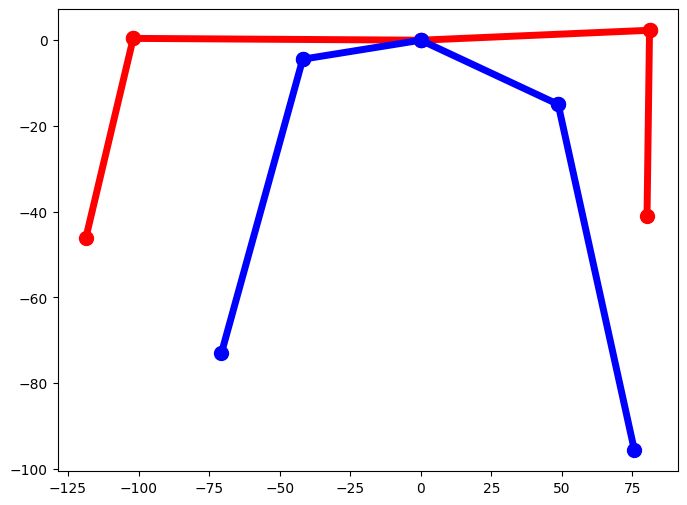

In [11]:
fig = plt.figure(figsize=(8,6))
sleap.nn.viz.plot_instance(sleap.Instance.from_numpy(centered_shark_tracks[3][anchor_idxs[3]], skeleton=shark_skeleton), lw=5, ms=20, cmap=["r"])
sleap.nn.viz.plot_instance(sleap.Instance.from_numpy(centered_shark_tracks[3][589], skeleton=shark_skeleton), lw=5, ms=20, cmap=["b"]);

In [12]:
maxes_x = [max([np.nanmax(rotated_remora_tracks[i], axis=(0,1))[0], np.nanmax(centered_shark_tracks[i], axis=(0,1))[0]]) \
         for i in range(len(rotated_remora_tracks))]
maxes_y = [max([np.nanmax(rotated_remora_tracks[i], axis=(0,1))[1], np.nanmax(centered_shark_tracks[i], axis=(0,1))[1]]) \
         for i in range(len(rotated_remora_tracks))]
mins_x = [min([np.nanmin(rotated_remora_tracks[i], axis=(0,1))[0], np.nanmin(centered_shark_tracks[i], axis=(0,1))[0]]) \
          for i in range(len(rotated_remora_tracks))]
mins_y = [min([np.nanmin(rotated_remora_tracks[i], axis=(0,1))[1], np.nanmin(centered_shark_tracks[i], axis=(0,1))[1]]) \
          for i in range(len(rotated_remora_tracks))]
maxes = np.array([maxes_x, maxes_y])
mins = np.array([mins_x, mins_y])

In [13]:
def make_trail_movies(shark_tracks, remora_tracks, video_names, track_maxes, track_mins, shark_skeleton, trail_length=25, colors='tab10'):
    cmap = matplotlib.cm.get_cmap(colors)
    
    for video_idx, vid_name in enumerate(video_names):
        shark_track = shark_tracks[video_idx]
        remora_track = remora_tracks[video_idx]
        n_remoras = remora_track.shape[1]

        writer = imageio.get_writer(vid_name, fps=30)
        upper_lims = track_maxes[:, video_idx]
        lower_lims = track_mins[:, video_idx]

        for frame_idx in progress(range(remora_track.shape[0])):
            fig = plt.figure(figsize=(16, 12), dpi=120, facecolor='w')
            sleap.nn.viz.plot_instance(sleap.Instance.from_numpy(shark_track[frame_idx], skeleton=shark_skeleton), lw=5, ms=40, cmap=["c"])
    
            for remora in range(n_remoras):
                if frame_idx < trail_length:
                    plt.plot(remora_track[:frame_idx, remora, 0], remora_track[:frame_idx, remora, 1], c=cmap(remora))
                else:
                    plt.plot(remora_track[frame_idx - trail_length:frame_idx, remora, 0], \
                             remora_track[frame_idx - trail_length:frame_idx, remora, 1], c=cmap(remora))
                plt.plot(remora_track[frame_idx, remora, 0], remora_track[frame_idx, remora, 1], marker='o', ms=20, c=cmap(remora))
        
            plt.xlim([lower_lims[0] - 10, upper_lims[0] + 10])
            plt.ylim([lower_lims[1] - 10, upper_lims[1] + 10])
            plt.xticks([])
            plt.yticks([])
    
            plt.savefig('viz/trail_frame.png', format='png', dpi='figure')
            img = imageio.imread('viz/trail_frame.png')
            writer.append_data(img)
            plt.close(fig)
    
        writer.close()

In [14]:
videos = [f'viz/video_{x+1}_trails.mp4' for x in range(len(trans_vecs))]
make_trail_movies(shark_tracks=centered_shark_tracks, remora_tracks=rotated_remora_tracks, video_names=videos, track_maxes=maxes, track_mins=mins, shark_skeleton=shark_skeleton)

Output()

Output()

Output()

Output()

## Superimposing image onto videos

In [15]:
def to_homogeneous(x):
    """Tranform x to homogeneous coordinates.
    
    Args:
        x: Array of shape (dim_1, ..., dim_n, 2).
        
    Returns:
        Homogenous representation of array with shape (dim_1, ..., dim_n, 3).
    """
    pad_pattern = []
    
    for dim in range(len(x.shape)):
        if dim == len(x.shape) - 1:
            pad_pattern.append((0,1))
        else:
            pad_pattern.append((0,0))
            
    return np.pad(x, pad_pattern, mode='constant', constant_values = 1)

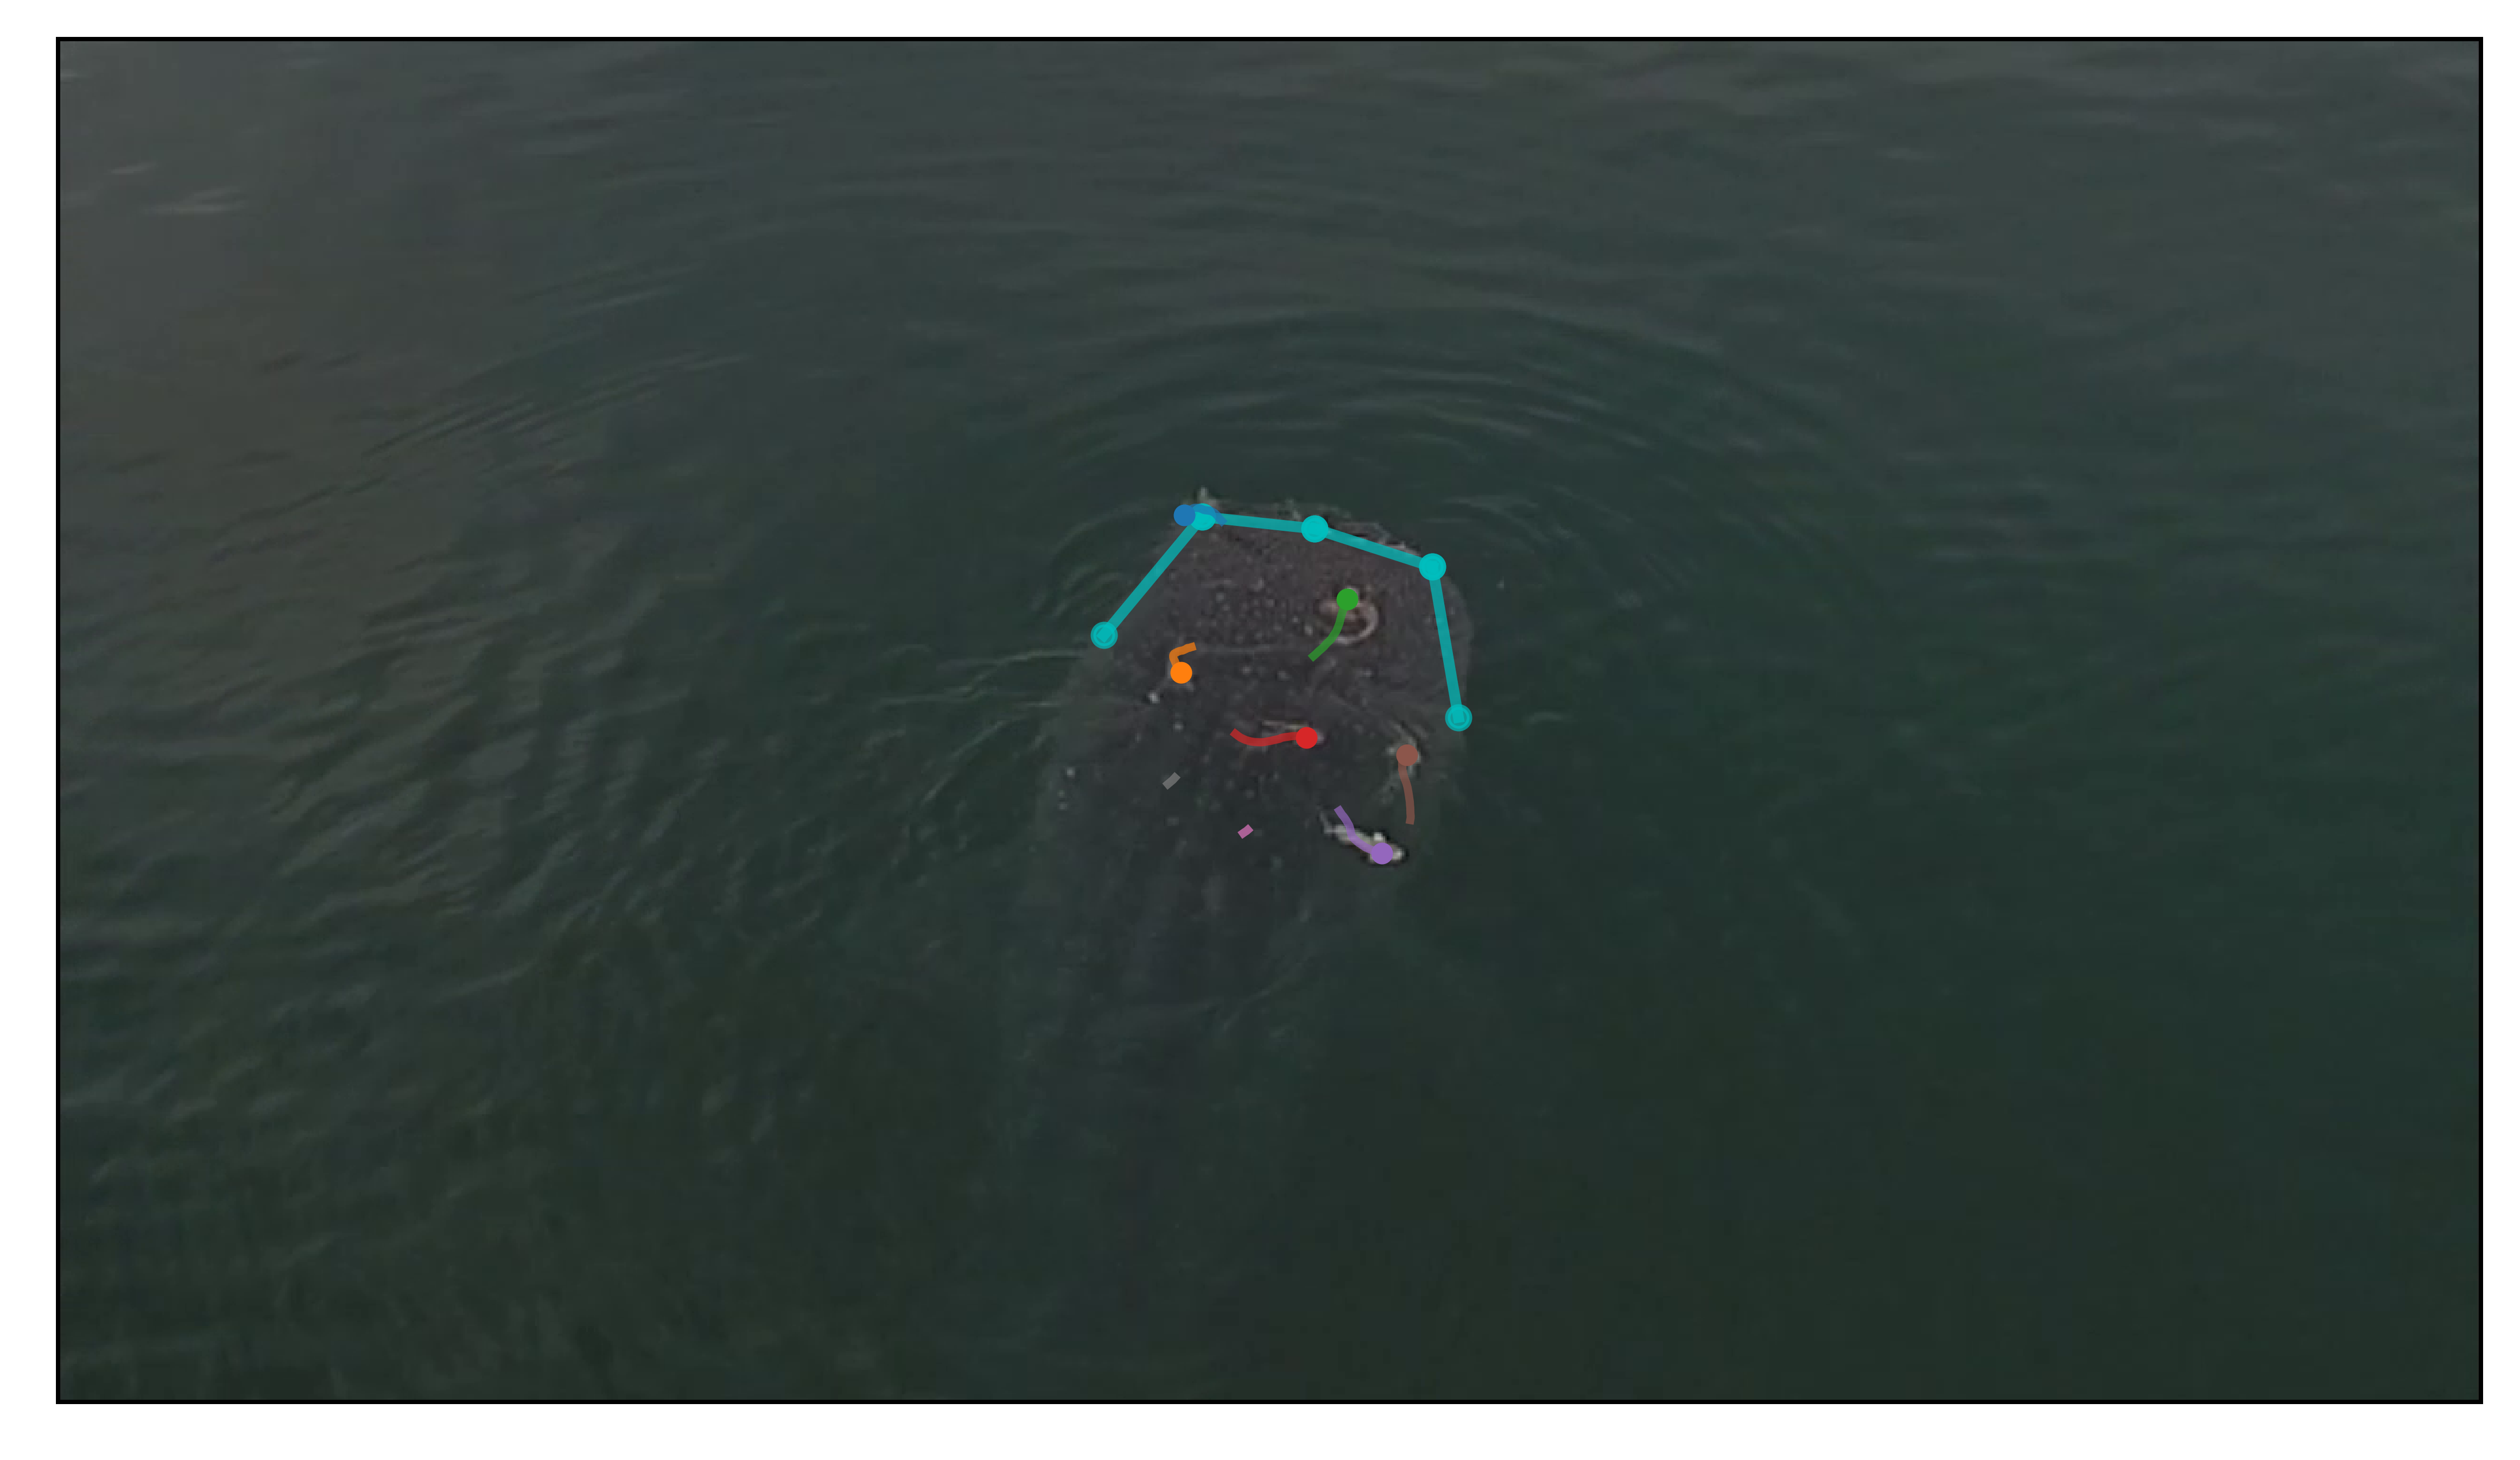

In [16]:
# Generating figures for presentation 
videos = """
videos/RemoraWS_vid_01.mp4
videos/RemoraWS_vid_02.mp4
videos/RemoraWS_vid_03.mp4
videos/RemoraWS_vid_04.mp4
""".strip().split()

v = 2
t = 199
trail_length = 25
vid = sleap.load_video(videos[v])
img = vid[t].squeeze()
shark = smoothed_shark_tracks[v][t]
remoras = smoothed_remora_tracks[v][:, :, REMORA_CENTROID_NODE]
n_remoras = remoras.shape[1]
cmap = matplotlib.cm.get_cmap('tab10')

fig = plt.figure(figsize=(8,6), dpi=720, facecolor='w')
sleap.nn.viz.plot_instance(sleap.Instance.from_numpy(shark, skeleton=shark_skeleton), lw=2, ms=8, cmap=['c'], alpha=0.7)
for remora in range(n_remoras):
    plt.plot(remoras[t - trail_length:t, remora, 0], remoras[t - trail_length:t, remora, 1], c=cmap(remora), lw=1.5, alpha=0.7)
    plt.plot(remoras[t, remora, 0], remoras[t, remora, 1], c=cmap(remora), marker='o', ms=3)
plt.imshow(img)
plt.xticks([])
plt.yticks([]);
plt.savefig('figs/film_img_1.png', format='png', dpi='figure')

In [20]:
def make_egocentric_movies(shark_tracks, remora_tracks, rots, t_vecs, vid_names, raw_vids, shark_skeleton, trail_length=25, img_size=(1280,720), dpi=120, offset=200, colors='tab10', remora_centroid_node=REMORA_CENTROID_NODE):
    cmap = matplotlib.cm.get_cmap(colors)
    viz_offset = np.array([img_size[0] / 2, img_size[1]/2 + offset])
    
    for v, vid_name in enumerate(vid_names):
        shark_track = shark_tracks[v]
        remora_track = remora_tracks[v][:, :, remora_centroid_node, :]
        n_remoras = remora_track.shape[1]
        
        # homog_t1 
        trans_padding = np.broadcast_to(np.array([[1, 0], [0, 1], [0, 0]]), (t_vecs[v].shape[0], 3, 2))
        homog_t1s = np.concatenate([trans_padding, -to_homogeneous(t_vecs[v]).transpose((0,-1,1))], axis=-1)
        homog_t1s[:, -1, -1] = 1
        # homog_t2
        homog_t2s = np.pad(rots[v], ((0, 0), (0, 1), (0, 1)), mode='constant', constant_values=[0, 0])
        homog_t2s[:, -1, -1] = 1
        #homog_t3
        homog_t3s = np.concatenate([trans_padding, to_homogeneous(np.broadcast_to(viz_offset, (len(t_vecs[v]), 1, 2))).transpose((0,-1,1))], axis=-1)
        # T
        Ts = homog_t3s @ homog_t2s @ homog_t1s
        # Shark
        P = np.einsum('fik,fjk->fji', Ts, to_homogeneous(shark_track))[..., :2]  # (frames, nodes, 2)
        # Remora 
        R = np.einsum('fik,fjk->fji', Ts, to_homogeneous(remora_track))[..., :2] # (frames, tracks, 2)
        
        np.save(f'data/normalized_shark_track_video_{v+1}.npy', P)
        np.save(f'data/normalized_remora_track_video_{v+1}.npy', R)
        
        # Making movie 
        writer = imageio.get_writer(vid_name, fps=30, format="FFMPEG", quality=7)
        raw_vid = sleap.load_video(raw_vids[v])
        for frame_idx in progress(range(R.shape[0])):
            img = raw_vid[frame_idx].squeeze()
            img_tformed = cv2.warpAffine(img, Ts[frame_idx, :2], img_size)
            
            fig = plt.figure(figsize=(img_size[0] / dpi, img_size[1] / dpi), dpi=dpi)
            ax = fig.add_axes([0, 0, 1, 1], frameon=False)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.autoscale(tight=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)
            
            plt.imshow(img_tformed)
            sleap.nn.viz.plot_instance(sleap.Instance.from_numpy(P[frame_idx], skeleton=shark_skeleton), lw=2, ms=8, cmap=['c'], alpha=0.7)
            
            for remora in range(n_remoras):
                if frame_idx < trail_length:
                    plt.plot(R[:frame_idx, remora, 0], R[:frame_idx, remora, 1], c=cmap(remora), lw=1.5, alpha=0.7)
                else:
                    plt.plot(R[frame_idx - trail_length:frame_idx, remora, 0], R[frame_idx - trail_length:frame_idx, remora, 1], c=cmap(remora), lw=1.5, alpha=0.7)
                plt.plot(R[frame_idx, remora, 0], R[frame_idx, remora, 1], c=cmap(remora), marker='o', ms=4)
        
            plt.ylim(plt.ylim()[::-1])
    
            plt.savefig('viz/trail_frame.png', format='png', dpi='figure')
            img = imageio.imread('viz/trail_frame.png')
            writer.append_data(img)
            plt.close(fig)
    
        writer.close()

In [21]:
videos = [f'viz/superimpose_video_{x+1}_trails.mp4' for x in range(len(trans_vecs))]
raw_videos = [f'videos/RemoraWS_vid_0{x+1}.mp4' for x in range(len(trans_vecs))]
make_egocentric_movies(shark_tracks=smoothed_shark_tracks, remora_tracks=smoothed_remora_tracks, rots=rot_mats, t_vecs=trans_vecs, vid_names=videos, raw_vids=raw_videos, shark_skeleton=shark_skeleton)

Output()

Output()

Output()

Output()

([], [])

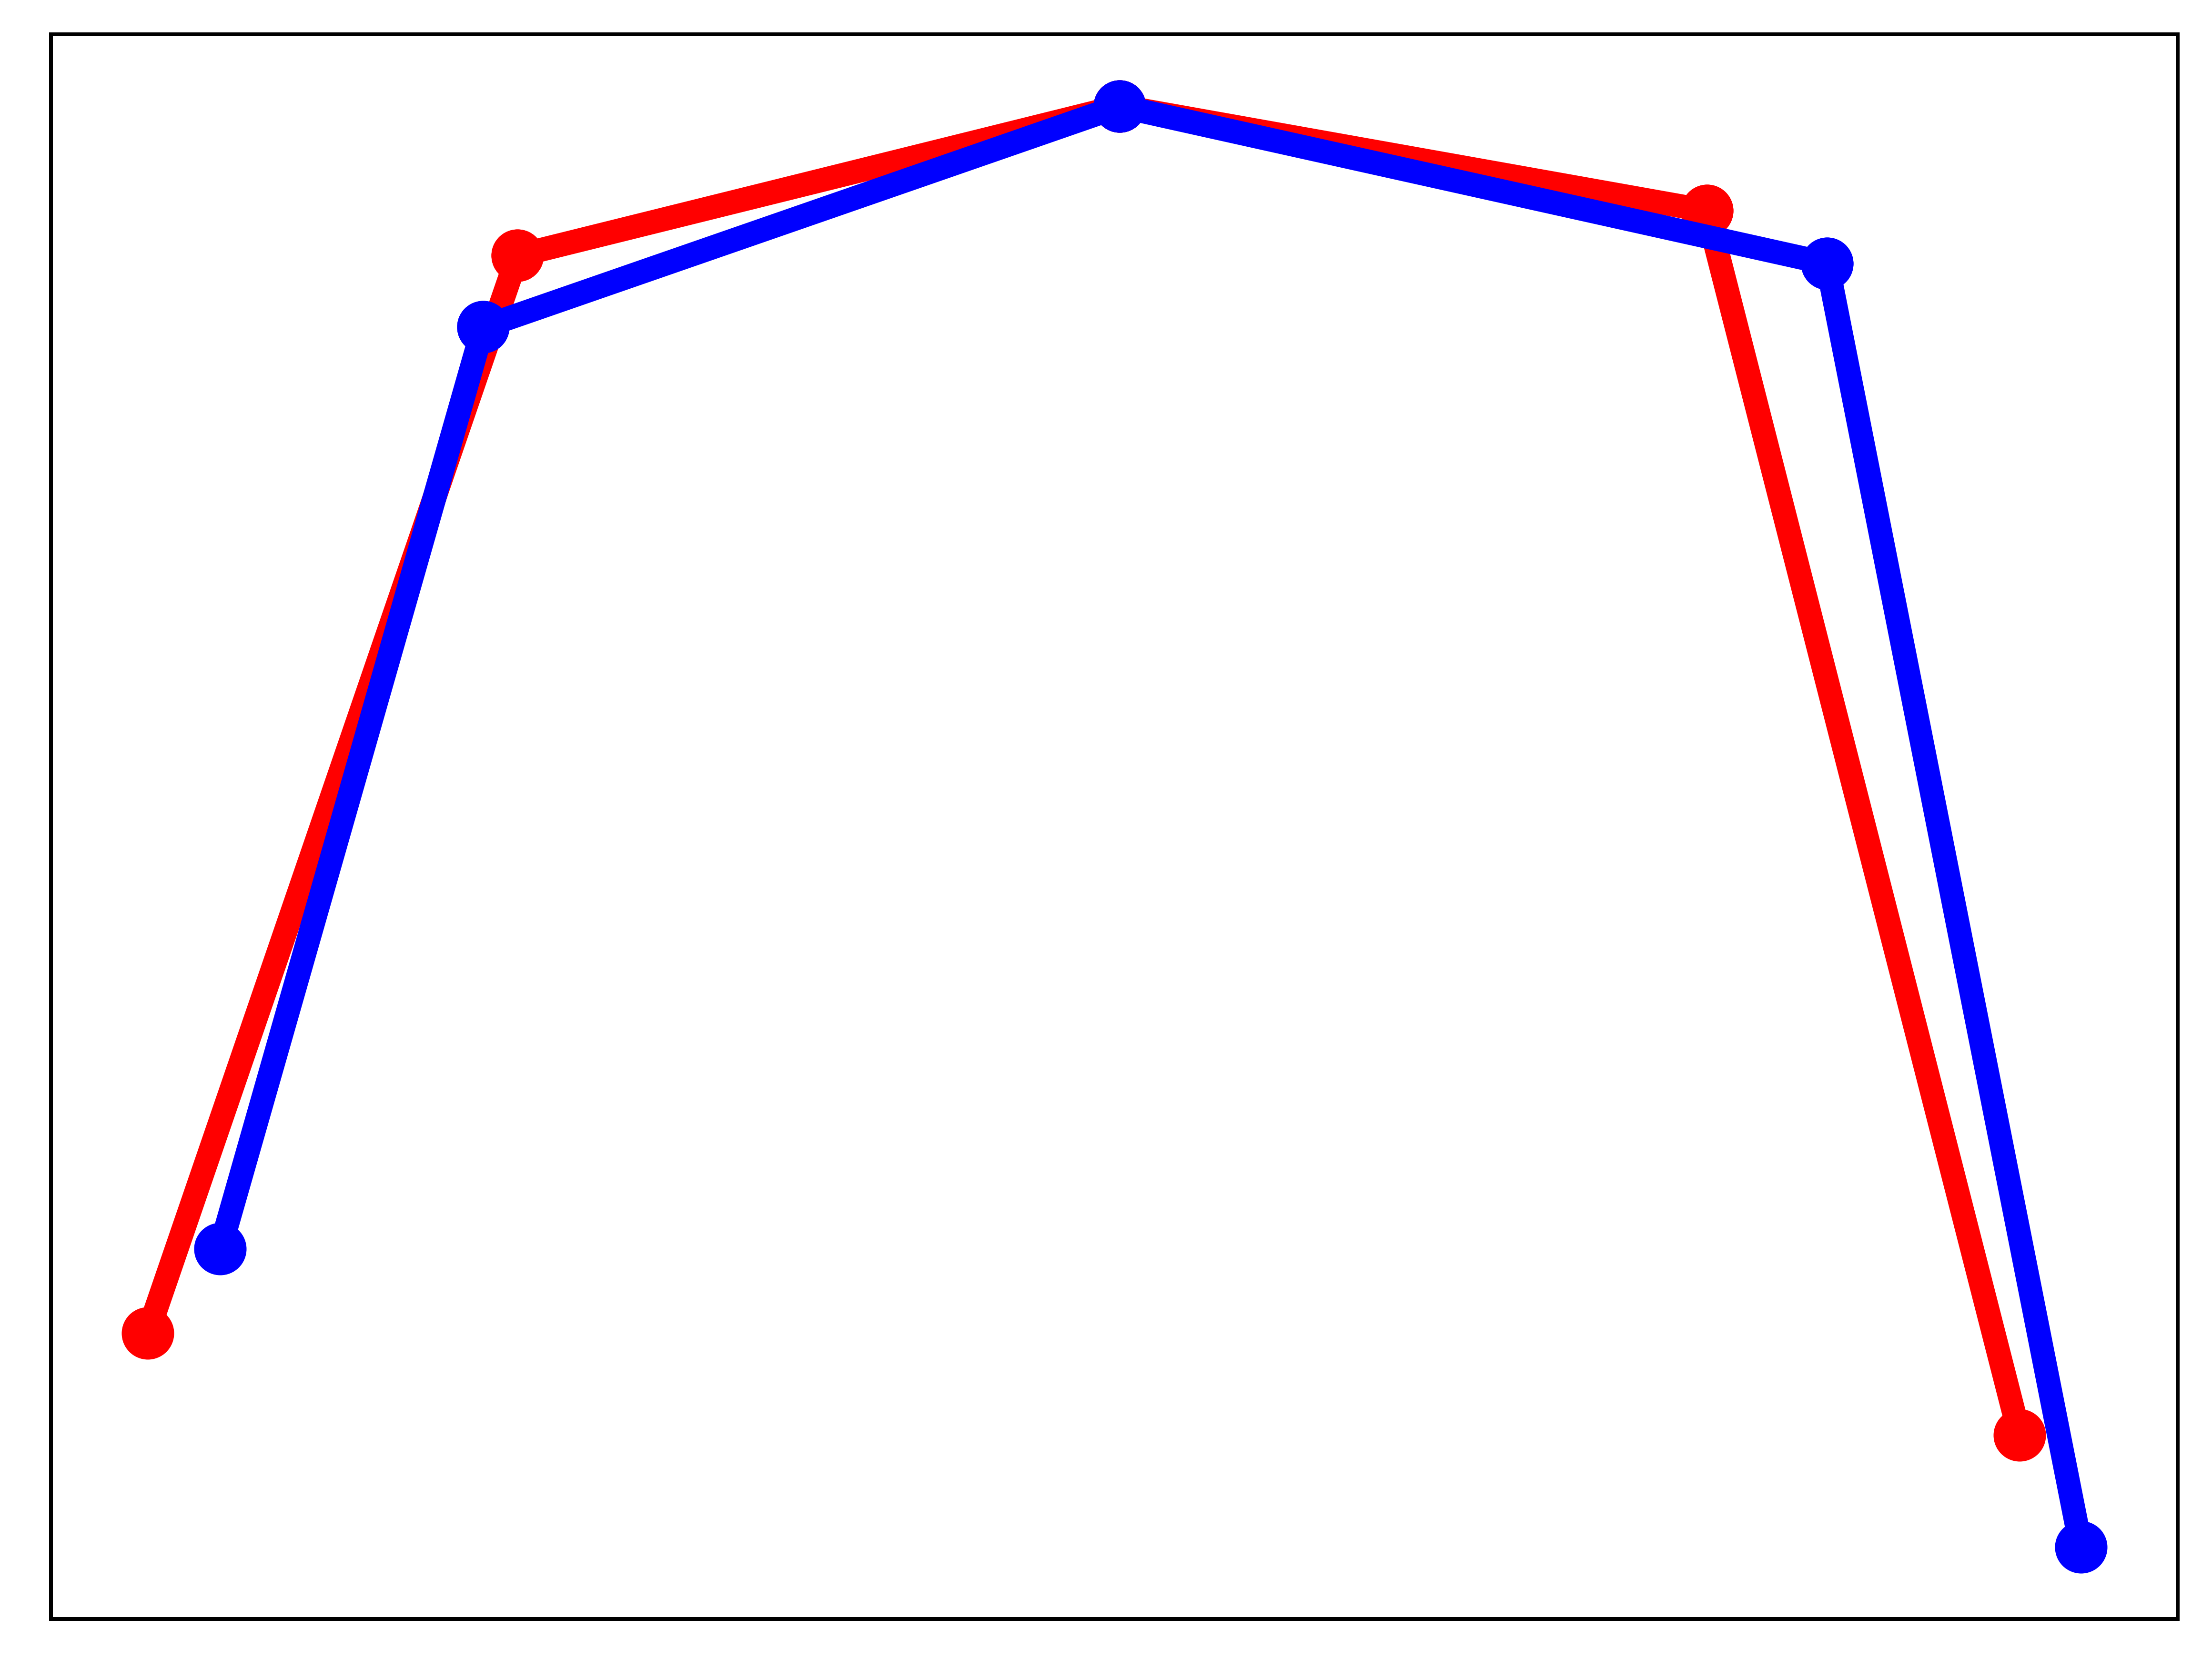

In [17]:
P = np.load('data/normalized_shark_track_video_2.npy')

fig = plt.figure(figsize=(8,6), dpi=720, frameon=False)
sleap.nn.viz.plot_instance(sleap.Instance.from_numpy(P[50], skeleton=shark_skeleton), lw=5, ms=20, cmap=["r"])
sleap.nn.viz.plot_instance(sleap.Instance.from_numpy(P[199], skeleton=shark_skeleton), lw=5, ms=20, cmap=["b"])
plt.yticks([])
plt.xticks([])
plt.savefig('figs/skeleton_comp.png', format='png', dpi='figure');